In [2]:
from functools import partial
import itertools
import numpy as np
from tqdm import tqdm

import jax
jax.config.update("jax_default_matmul_precision", "highest")
import jax.numpy as jnp
from jax.scipy.linalg import expm
from jax_tqdm import scan_tqdm

from gauge_field_utils import coef_to_lie_group, wilson_action, mean_wilson_rectangle
from integrators import int_LF2, int_MN2_omelyan, int_MN4_takaishi_forcrand

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
def HMC(beta, afn, nfev_approx):
    action_fn = lambda x: afn(coef_to_lie_group(x), beta)
    action_grad_fn = jax.grad(action_fn)
    
    def step_fn(coef, tau, random_key):
        key1, key2 = jax.random.split(random_key, num=2)
        p0 = jax.random.normal(key1, shape=coef.shape, dtype=coef.dtype)

        H0 = action_fn(coef) + jnp.sum(p0 * p0) / 2
        coef_prop, pt = int_MN2_omelyan(coef, p0, action_grad_fn, tau, nfev_approx)
        Ht = action_fn(coef_prop) + jnp.sum(pt * pt) / 2

        dH = Ht - H0
        p_acc = jnp.minimum(1, jnp.exp(-dH))

        coef_next = jax.lax.cond(
            jax.random.uniform(key2) < p_acc,
            lambda: coef_prop,
            lambda: coef
        )

        return coef_next, (dH, p_acc)

    return step_fn

def warmup_tint(coef, beta, random_key, observable_fn, tau, iters=2000, nfev_approx=20):
    stepper_fn = jax.jit(HMC(beta, wilson_action, nfev_approx))
    
    @scan_tqdm(iters, print_rate=1, tqdm_type="notebook")
    def warmup_step(carry, step):
        coef, rng_key = carry
        rng_key, k1 = jax.random.split(rng_key)
        
        coef, (dH, p_acc) = stepper_fn(coef, tau, k1)
        o = observable_fn(coef)
        jax.debug.print("warmup step {step} ; o={o} ; dH={dH} ; p_acc={p_acc}", step=step, o=o, dH=dH, p_acc=p_acc)

        carry = (coef, rng_key)
        return carry, o

    (coef, random_key), O = jax.lax.scan(
        warmup_step,
        init=(coef, random_key),
        xs=np.arange(iters),
        length=iters
    )

    return coef, O

@partial(jax.jit, static_argnames=["R_range", "T_range"])
def calculate_wilson_loops(gauge_coef, R_range, T_range):
    R_min, R_max = R_range
    T_min, T_max = T_range
    wilson_loop_values = jnp.array([mean_wilson_rectangle(coef_to_lie_group(gauge_coef), R, T, time_unique=False) for R, T in itertools.product(range(R_min, R_max+1), range(T_min, T_max+1))]).reshape(R_max-R_min+1, T_max-T_min+1)
    return wilson_loop_values

In [4]:
L = (16, 8, 8, 8)
R_range = (1, 8)
T_range = (1, 16)

random_key, key1, key2 = jax.random.split(jax.random.key(0), num=3)
coef = jax.random.normal(key1, shape=(*L, 4, 8), dtype=jnp.float32)

In [5]:
coef, tint, O = warmup_tint(
    coef,
    beta=1.0,
    random_key=random_key,
    observable_fn=jax.jit(lambda x: mean_wilson_rectangle(coef_to_lie_group(x), 1, 1, time_unique=False).real),
    tau=1.0,
    iters=2000,
    nfev_approx=20
)

2025-03-07 19:15:04.324759: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.


Running for 2,000 iterations:   0%|          | 0/2000 [00:00<?, ?it/s]

warmup step 0 ; o=0.12826785445213318 ; dH=0.21875 ; p_acc=0.8035225868225098
warmup step 1 ; o=0.14446763694286346 ; dH=0.265625 ; p_acc=0.7667266130447388
warmup step 2 ; o=0.15274927020072937 ; dH=0.078125 ; p_acc=0.9248487949371338
warmup step 3 ; o=0.1602262705564499 ; dH=0.03125 ; p_acc=0.9692332148551941
warmup step 4 ; o=0.15743069350719452 ; dH=0.078125 ; p_acc=0.9248487949371338
warmup step 5 ; o=0.16520753502845764 ; dH=-0.015625 ; p_acc=1.0
warmup step 6 ; o=0.15943512320518494 ; dH=0.046875 ; p_acc=0.9542067050933838
warmup step 7 ; o=0.16032937169075012 ; dH=0.015625 ; p_acc=0.9844964742660522
warmup step 8 ; o=0.15355317294597626 ; dH=0.03125 ; p_acc=0.9692332148551941
warmup step 9 ; o=0.1528140902519226 ; dH=0.015625 ; p_acc=0.9844964742660522
warmup step 10 ; o=0.16133961081504822 ; dH=-0.03125 ; p_acc=1.0
warmup step 11 ; o=0.16250234842300415 ; dH=0.015625 ; p_acc=0.9844964742660522
warmup step 12 ; o=0.16046272218227386 ; dH=0.03125 ; p_acc=0.9692332148551941
warmu

ValueError: not enough values to unpack (expected 3, got 2)

In [14]:
wilson_loops = []

for i in tqdm(range(20000)):
    random_key, key1 = jax.random.split(random_key)
    coef = HMC_trajectory(coef, beta=6.7, steps=80, dt=3e-5, random_key=key1)["q_next"]

    # Calculate wilson loops
    wilson_loops.append(calculate_wilson_loops(coef, R_range, T_range))

In [14]:
wilson_loops = jnp.array(wilson_loops)
mean_loops = jnp.real(wilson_loops[200:].mean(axis=0)).copy()
omrt_loops = 1 - mean_loops/3

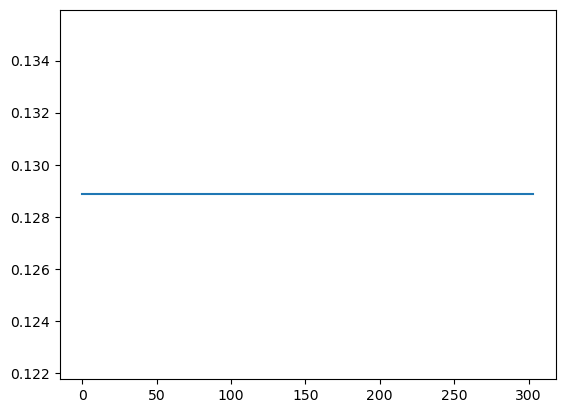

In [15]:
plt.plot(wilson_loops[:, 0, 0].real)
plt.show()

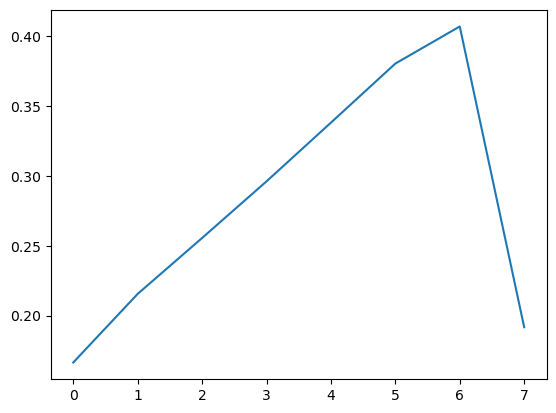

In [51]:
i=7
plt.plot(jnp.log(mean_loops[:,i]/mean_loops[:,i+1]))
plt.show()